# Credit default - Mohammed El Mendili :
In this notebook, we will work on the dataset given in the repisotory. We will train and evaluate different Machine Learning models in order to design a robust and efficient ML model for credit cards' prediction. particularly, we will try to deal with the problem of Imbalanced classes using different methods (Class re-weighning, Oversampling, Undersampling, Ensemble Methods) Our outline is the following: 

1. Importing, Pre-processing and Feature engineering
2. Data Exploratoy 
3. Classification models and Improvements
6. Evaluation and validation

#### Important importations:

In [347]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # for tuning parameter


from xgboost import XGBClassifier
import xgboost as xgb

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Importing, Pre-processing and Feature engineering

We will begin by importing the dataset using pandas.

In [348]:
credit = pd.read_csv('CreditTraining.csv')
credit

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,5389,0,Non Existing Client,09/04/1976,19/10/2011,NP_Client,University,Married,2.0,1,36,1.0,G,25/11/2011,Sales,Owned,1,NaN,C
5376,1358,1,Existing Client,27/05/1982,22/06/2011,NP_Client,University,Married,3.0,15,"24,816",1.0,C,11/07/2011,Sales,Owned,1,31/10/2012,L
5377,2502,0,Non Existing Client,19/10/1950,15/08/2011,NP_Client,University,Divorced,0.0,14,"14,4",30.0,C,16/08/2011,Branch,Old rent,1,31/03/2013,B
5378,6712,0,Non Existing Client,01/08/1983,15/01/2012,NP_Client,University,Married,1.0,1,36,1.0,G,19/01/2012,Sales,Owned,1,NaN,C


There are 19 columns in this dataset. One of these columns is "Y" that means whether there is credit default or not, others are explonatory variables.

Some variables seems to be irrelevant for the prediction and should be dropped from our dataset. For example, $\textbf{Id_Customer}$ is usually random. As for $\textbf{Prod_Closed_Date}$, it contains a lot of missing data and seems to be irrelevant too. We will drop them.

Another problem is for $\textbf{Net_Annual_Income}$. First, its form is "String" and should be transformed to a "Float" form. Second, we will use its logarithm to reduce its range. This wil be done using "to_dec" function.

In [349]:


#Some values in Net_Annual_Income have ',' instead of '.'. We will correct this using the following funtion:
def to_dec(x):
    if(type(x) == str):
        return np.log(float(x.replace(',', '.')))
    return np.log(float(x))

credit['Log_income'] = credit['Net_Annual_Income'].apply(to_dec)
credit = credit.drop(['Net_Annual_Income','Id_Customer','Prod_Closed_Date'], axis = 1)  

Now, we will set all the date variables to a standard format:

In [350]:
#Converting the dates to a standard format
credit["BirthDate"] = pd.to_datetime(credit["BirthDate"],format='%d/%m/%Y',infer_datetime_format=False)
credit["Prod_Decision_Date"] = pd.to_datetime(credit["Prod_Decision_Date"],format='%d/%m/%Y',infer_datetime_format=False)
credit["Customer_Open_Date"] = pd.to_datetime(credit["Customer_Open_Date"],format='%d/%m/%Y',infer_datetime_format=False)

Now that we have all the date variables in the same format, it is necessary to interprete them accordingly in order to transform them to float variables. First, we should find a $\textbf{relevant}$ reference for dates. An intuitive idea would be to use $\textbf{Prod_Decision_Date}$ and interpret the other variables accordingly. For example, $\textbf{BirthDate}$ wil become the age of the customer when grant's decision is made, and so on for the other variables. Indeed we will drop the variable $\textbf{Prod_Decision_Date}$ because it seems irrelevant when used in its absolute format.



In [351]:
credit["Age"] = (credit["Prod_Decision_Date"].dt.year - credit["BirthDate"].dt.year)
credit["Customer_Open_Age"] = (credit["Prod_Decision_Date"] - credit["Customer_Open_Date"]).dt.days

credit=credit.drop(["Customer_Open_Date","Prod_Decision_Date","BirthDate"],axis=1)

#### Dealing with categorical variables:

We will deal with each variable independently

#### Marital_Status

We will see the distribution of credit defaults according to this variable

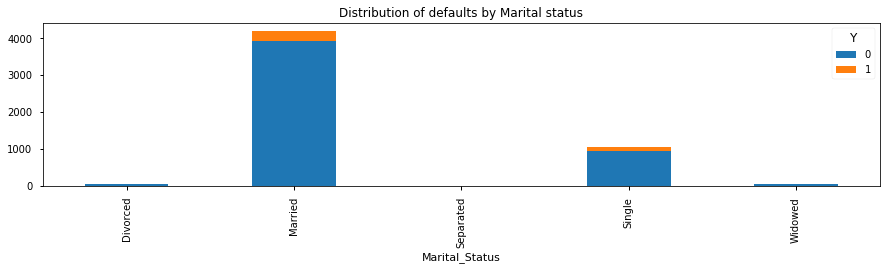

In [352]:
credit.groupby(["Marital_Status", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Marital status")
plt.show()

The labels $\textbf{Divorced, Separated and Widowed}$ are very scarce and they aren't really discriminative for credit default prediction. We will merge them with the $\textbf{Single}$ class.

$\textbf{Single}$ = Single + Separated + Divorced Widowed (Labeled 1)

In [353]:
def process_marital(x):
    if x!="Married": y=1.
    else: y=0.
    return y

credit['Marital_Status'] = credit['Marital_Status'].apply(process_marital)


#### Customer_Type:
There is only two types of clients. We will make a 0-1 encoding to this variable. 

However, according to the graph below, it seems that it is not a discriminative variable since both existing and nor existing clients have approximately the same percentage of defaults.

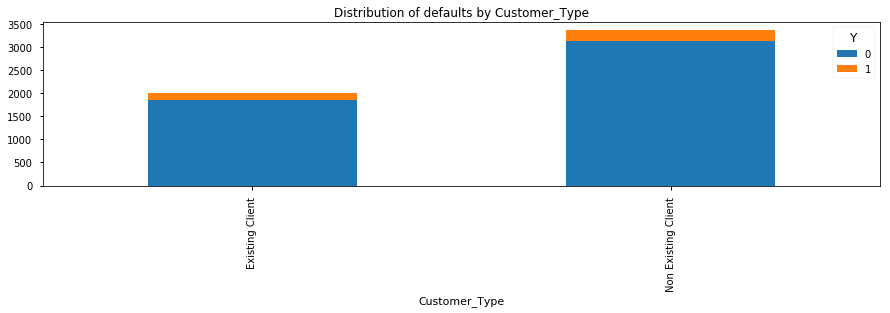

In [354]:
def process_customer_type(x):
    if x=="Existing Client": y=1.
    else: y=0.
    return y


credit.groupby(["Customer_Type", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Customer_Type")
plt.show()

credit['Customer_Type'] = credit['Customer_Type'].apply(process_customer_type)


#### Educational Level:
Intuitively, the more educated a customer is the more he would be less prone to default (He is most probably more stable, better job, etc).

We will code this variable using the following: 
- Secondary or less: 0
- Diploma: 1
- University: 2
- Master/PhD: 3

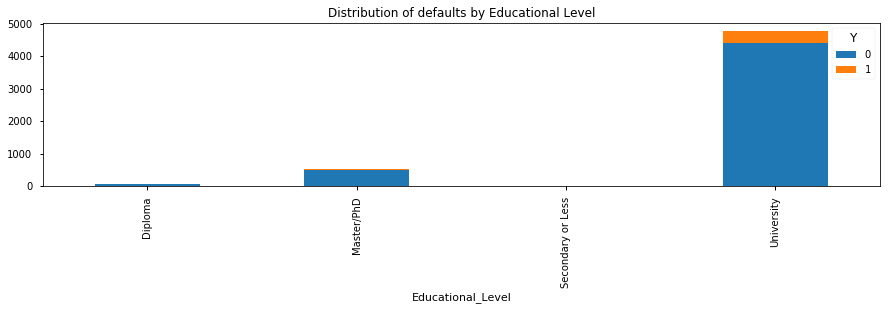

In [355]:
def process_educational_level(x):
    if x=="Secondary or Less": return 0
    if x=="Diploma": return 1
    if x=="University": return 2
    if x=="Master/PhD": return 3


credit.groupby(["Educational_Level", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Educational Level")
plt.show()

credit['Educational_Level'] = credit['Educational_Level'].apply(process_educational_level)


In [356]:
credit.head()

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,Log_income,Age,Customer_Open_Age
0,0,0.0,NP_Client,2,0.0,3.0,1,1.0,C,Sales,Owned,1,B,3.583519,35,1
1,0,1.0,P_Client,2,0.0,0.0,12,2.0,C,Sales,Parents,1,G,2.890372,37,876
2,0,0.0,NP_Client,2,0.0,2.0,10,1.0,C,Sales,Owned,1,B,3.583519,39,1
3,1,1.0,NP_Client,2,0.0,3.0,3,1.0,C,Sales,New rent,1,L,3.583519,29,13
4,0,0.0,NP_Client,2,0.0,2.0,1,1.0,C,Sales,Owned,1,D,3.583519,59,1


#### P_Client:
We will use 0-1 encoding. 0 for NP_client and 1 for P_Client

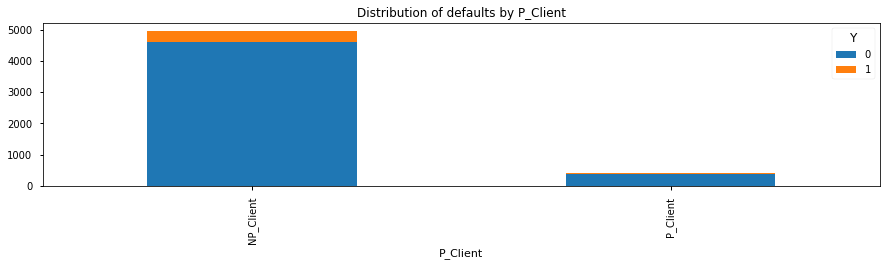

In [357]:
credit.groupby(["P_Client", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by P_Client")
plt.show()

In [358]:
def process_p_client(x):
    if x=="NP_Client": y=0.
    else: y=1.
    return y

credit['P_Client'] = credit['P_Client'].apply(process_p_client)

#### Prod_Sub_Category:

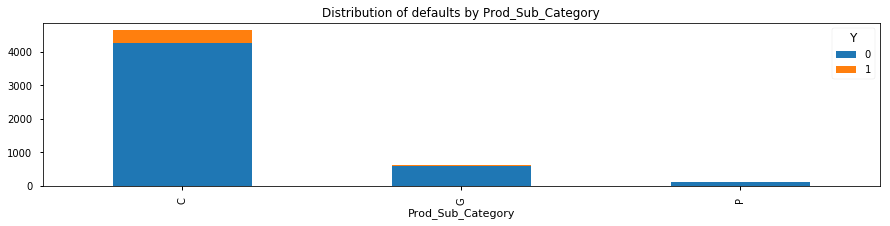

In [359]:
credit.groupby(["Prod_Sub_Category", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Prod_Sub_Category")
plt.show()

In [360]:
def process_sub_cat(x):
    if x=="P": y=0.
    if x=="G": y=1
    else: y=2
    return y

credit['Prod_Sub_Category'] = credit['Prod_Sub_Category'].apply(process_sub_cat)

#### Source:

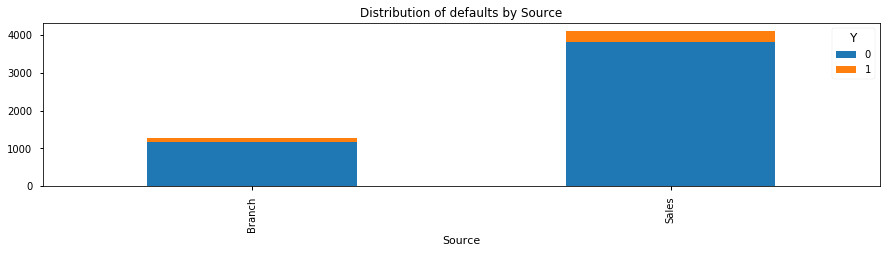

In [361]:
credit.groupby(["Source", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Source")
plt.show()

In [362]:
def process_source(x):
    if x=="Branch": y=1.
    if x=="Sales": y=0
    return y

credit['Source'] = credit['Source'].apply(process_source)

### Prod_Category

The transformation here is tricky. We have 13 possible values for the product. If we naively labeled them into 0,1,2,..,12, the model could learn that there is an underlying order between these labels. One solution is to fix labels to the percentage of defaults in this label. This will ensure a possible order of impact on default. 

One can also use a one-hot encoding for each label. We tried this and gave modest results with adding huge number of unecessary columns.

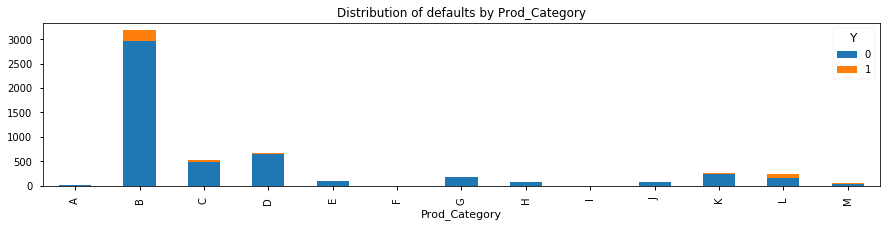

In [363]:
credit.groupby(["Prod_Category", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Prod_Category")
plt.show()

In [364]:
def process_prod_cat(x):
    y=credit[credit["Prod_Category"]==x]["Y"].mean()
    return y

credit['Prod_Category'] = credit['Prod_Category'].apply(process_prod_cat)

#### Type_Of_Residence

Here we will merge New rent, Old rent to : 1
Company, Owned, Parents : 0 (As it seems to be more stable, the customer doesn't pay rent actually)

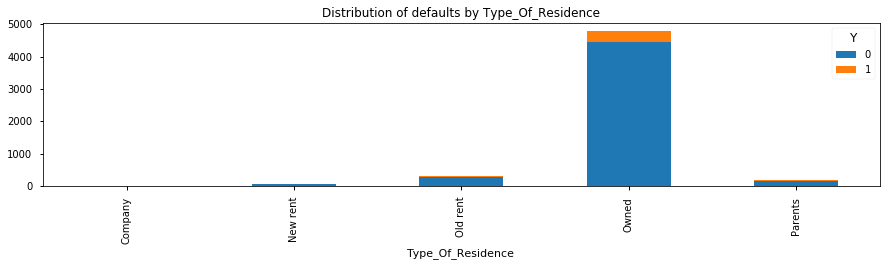

In [365]:
credit.groupby(["Type_Of_Residence", "Y"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,3)) 
plt.title("Distribution of defaults by Type_Of_Residence")
plt.show()

In [366]:
def process_residence(x):
    if x=="Company" or x=="Owned" or x=="Parents": return 0
    else: return 1

credit['Type_Of_Residence'] = credit['Type_Of_Residence'].apply(process_residence)

In [367]:
credit.head()

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,Log_income,Age,Customer_Open_Age
0,0,0.0,0.0,2,0.0,3.0,1,1.0,2,0.0,0,1,0.067380,3.583519,35,1
1,0,1.0,1.0,2,0.0,0.0,12,2.0,2,0.0,0,1,0.005319,2.890372,37,876
2,0,0.0,0.0,2,0.0,2.0,10,1.0,2,0.0,0,1,0.067380,3.583519,39,1
3,1,1.0,0.0,2,0.0,3.0,3,1.0,2,0.0,1,1,0.360169,3.583519,29,13
4,0,0.0,0.0,2,0.0,2.0,1,1.0,2,0.0,0,1,0.044776,3.583519,59,1


#### Handling missing data

Since there are only 6 rows with missing data, we will drop them.

In [368]:
null_data = credit[credit.isnull().any(axis=1)]
null_data

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,Log_income,Age,Customer_Open_Age
634,1,1.0,1.0,2,1.0,NaN,21,1.0,2,1.0,0,2,0.005319,3.514526,22,576
1879,0,0.0,0.0,2,0.0,0.0,10,10.0,2,0.0,0,1,0.067380,NaN,44,1
1987,0,0.0,0.0,3,1.0,0.0,10,NaN,2,1.0,0,2,0.044776,3.218876,27,7
2750,0,0.0,0.0,2,0.0,0.0,2,NaN,2,1.0,0,1,0.067380,4.682131,30,13
5045,0,1.0,0.0,3,0.0,NaN,10,10.0,2,0.0,0,1,0.067380,3.912023,62,2777
5144,0,0.0,0.0,2,0.0,0.0,11,0.0,2,1.0,1,2,0.067380,NaN,61,3


In [369]:
credit=credit.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

As for now, we have transformed all our data to a numerical vector that we could feed to ML models.

## 2. Data exploratory

We will begin by compute some statistics on our data.

In [370]:
credit.describe()
raw_df=credit

#### Examine the credit distribution

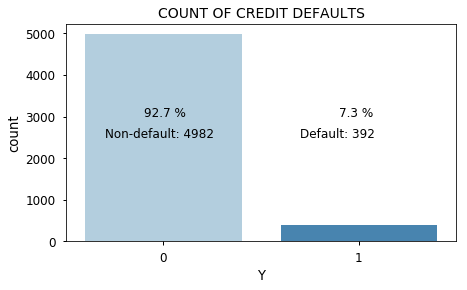

In [371]:
# The frequency of defaults
data=credit
yes = data.Y.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)
import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('Y',data=data, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 5000), xytext=(-0.3,2500), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 5000), xytext=(0.7, 2500), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 5000), xytext=(-0.1, 3000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 5000), xytext=(0.9, 3000), size=12)
plt.title('COUNT OF CREDIT DEFAULTS', size=14)
#Removing the frame
plt.box(True);

$\textbf{Conclusion}$: Our data is extremely imbalanced. We have only 7.3% of default. Hence, we should be very carefull when training ML models.

Now, let's take a look on the VIOLIN reprsentation of our standarized numerical columns (not categorical).

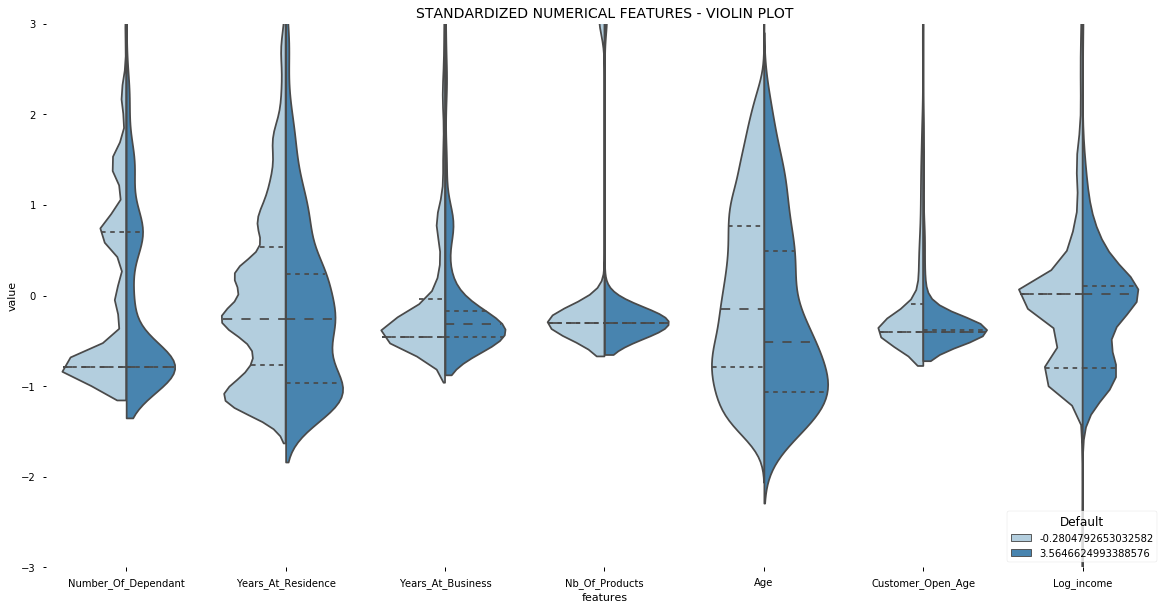

In [372]:
features=credit
stdX = (features - features.mean()) / (features.std())              
data_st = pd.melt(stdX [["Y","Number_Of_Dependant","Years_At_Residence","Years_At_Business","Nb_Of_Products","Age","Customer_Open_Age","Log_income"]],id_vars="Y",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,10))
sns.set_context('notebook', font_scale=1)
sns.violinplot(y="value", x="features", hue="Y", data=data_st,split=True, 
               inner="quart", palette='Blues')
plt.legend(loc=4, title= 'Default', facecolor='white')
plt.ylim([-3,3])
plt.title('STANDARDIZED NUMERICAL FEATURES - VIOLIN PLOT', size=14)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=False);

Perfectly summetric curves are likely to be non-discriminative. This plot will help us performin feature selection.

### Correlation Analysis:

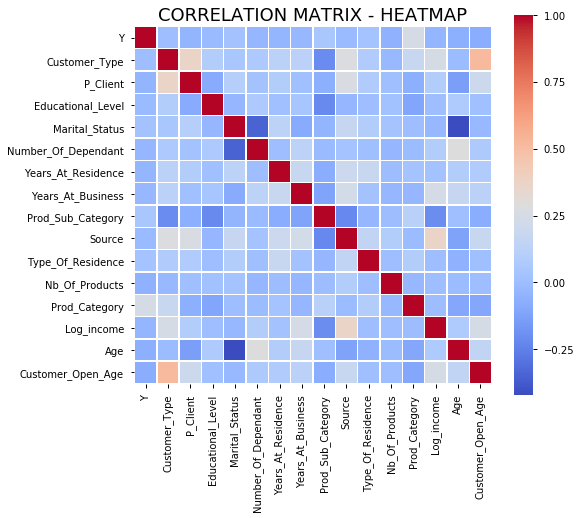

In [373]:
#  looking at correlations matrix, defined via Pearson function  
data_corr=credit
corr = data_corr.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

There is no STRONG correlation between any pair of vaiables. Thus, we will not drop any of them at this stage.

### Split and normalize the data

Here, we will split into: Train, Validation and Test sets. We will not TOUCH the test set until our training/selection are complete.

We will also normalize our data as it is important that variables be on the same scale in order to facilitate the training for ML models.

$\textbf{Note}$: As the data is imbalanced, we will $\textbf{stratify}$ our sampling. It means, we will try to have the same proportion of 1 in train and test data.

In [467]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(credit, test_size=0.3, stratify=credit["Y"])

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Y'))
bool_train_labels = train_labels != 0
test_labels = np.array(test_df.pop('Y'))

train_features = np.array(train_df)
test_features = np.array(test_df)

Below, we normalize our data. Note that the normalization is performed $\textbf{independently}$ on training and test sets. 

In [468]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

#val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
#print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
#print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (3761,)
Test labels shape: (1613,)
Training features shape: (3761, 15)
Test features shape: (1613, 15)


Now let's define some useful functions that will enable us to evaluate our models.

In [469]:
# This function plots the confusion matrix between predicted and true values.

def plot_cm(labels, predictions, p=0.5):
      print('Accuracy:', metrics.accuracy_score(labels,predictions))
      print('balanced_accuracy:', metrics.balanced_accuracy_score(labels,predictions))
      print('Precision:', metrics.precision_score(labels,predictions))
      print('Recall:', metrics.recall_score(labels,predictions))
      print('Roc-Auc:', metrics.roc_auc_score(labels,predictions)) 
      
      cm = confusion_matrix(labels, predictions > p)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix @{:.2f}'.format(p))
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

      print('Legitimate Credit Default Detected (True Negatives): ', cm[0][0])
      print('Legitimate Credit Default Incorrectly Detected (False Positives): ', cm[0][1])
      print('Credit Default Missed (False Negatives): ', cm[1][0])
      print('Credit Default Detected (True Positives): ', cm[1][1])
      print('Total Credit Default: ', np.sum(cm[1]))

In [470]:
# This function plots tha ROC curve between preducted and true labels. It is quite important to assess models on imbalanced data since the accuracy is a biased measure here.
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [471]:
# This function implements a stratified cross validation on the training set. The validation is based on ROC_AUC score since it is more convenient to imbalanced data
def cross_val(model,scores=["accuracy","balanced_accuracy","roc_auc","recall","precision","f1"]):
    
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
        scores_cv={}
        for score in scores:
             score_val = cross_val_score(model, train_features, train_labels, scoring=score, cv=cv, n_jobs=-1)
             scores_cv[score]=np.mean(score_val)
        return scores_cv
    
    


# 3. Classification models and improvements

the first step will be to train naive models on our dataset and see their performance. 

$\textbf{Remark}$: Since the data is imbalanced, the accuracy is not a good measure for our evaluation. We will use : Balanced_Accuracy, Recall and ROC_AUC

In [472]:

print("Support vector machine(SVM): ",cross_val(svm.SVC()))
print('K Nearest Neighbor Classifier: ',cross_val(neighbors.KNeighborsClassifier()))
print('Logistic Regression: ', cross_val(linear_model.LogisticRegression()))
print('XGBoost Classifier: ', cross_val(XGBClassifier()))

Support vector machine(SVM):  {'accuracy': 0.926083679466531, 'balanced_accuracy': 0.5149088316011232, 'roc_auc': 0.6176961859596072, 'recall': 0.033602693602693606, 'precision': 0.5246731307907778, 'f1': 0.06035564016809313}
K Nearest Neighbor Classifier:  {'accuracy': 0.920074736514933, 'balanced_accuracy': 0.5462901743084104, 'roc_auc': 0.6200203929923399, 'recall': 0.10875420875420876, 'precision': 0.35095494766671237, 'f1': 0.16414386409368298}
Logistic Regression:  {'accuracy': 0.9267216947811591, 'balanced_accuracy': 0.5152459782453986, 'roc_auc': 0.7108558093919508, 'recall': 0.033589225589225585, 'precision': 0.5063809523809524, 'f1': 0.06160271210699851}
XGBoost Classifier:  {'accuracy': 0.92422240117544, 'balanced_accuracy': 0.5249924331875387, 'roc_auc': 0.714156519543376, 'recall': 0.05767003367003366, 'precision': 0.4070447330447331, 'f1': 0.09965880017502408}


Altough these models have a good accuracy, their $\textbf{recall is very low}$. This is basically due to imbalanced data issues. In fact, a simple strategy to always label data as non-default would give an accuracy of 92,7% which is $\textbf{misleading}$. The recall measure as well as roc_auc give good evaluation of performance. 

## Class weighting, Class balancing,  Undersampling and Oversampling

The first solution we can imagine is to put some weight on "default" data on our loss function. This means when evaluation the loss, we count many times errors generated by a misclassification of "1" labels. This intends to force the model to learn to classify this class (i.e. avoid learning the all 0 strategy).

The literature suggests to put as weights: $w(0)=1$ and $w(1)=\frac{\% \text{of} 0}{\% \text{of} 1}=12.7$ (it is equivalent to balancing the dataset since we train on all the data on one time (this would be different if used this approach on neural networks where training is done on batches rather than the whole dataset). This could be implemented directly by the parameter class_weight in sklearn models.

We have also used a grid cross validation search for the best weighting possible. The results turned arround this number.

Let's test this on SVM and Log_reg (there is specific implementation for trees)

In [473]:
print("Support vector machine(SVM): ",cross_val(svm.SVC(class_weight="balanced")))
print('Logistic Regression: ', cross_val(linear_model.LogisticRegression(class_weight="balanced")))


Support vector machine(SVM):  {'accuracy': 0.7183177926591506, 'balanced_accuracy': 0.6187241299158109, 'roc_auc': 0.6800867855627056, 'recall': 0.5021548821548821, 'precision': 0.13127762160888623, 'f1': 0.20727302581716903}
Logistic Regression:  {'accuracy': 0.6734362549800799, 'balanced_accuracy': 0.6345512827598639, 'roc_auc': 0.7111685246690199, 'recall': 0.589037037037037, 'precision': 0.12632193101290232, 'f1': 0.20777542394305681}


### Grid search for the best parameter for SVM

In [386]:
model = svm.SVC(class_weight="balanced")
# define grid
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  # define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring="accuracy")
# execute the grid search
grid_result = grid.fit(train_features, train_labels)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914167 using {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.826939 (0.022228) with: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.750333 (0.030315) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.771972 (0.086541) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.914089 (0.007726) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.158588 (0.256386) with: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.796388 (0.020376) with: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.704739 (0.024136) with: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.676210 (0.034064) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.773527 (0.105409) with: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.914167 (0.007758) with: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.820577 (0.015357) with: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.729319 (0.022873) with: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.703888 (0.026835) with: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.588751 (0.055971) with: {'C': 10, 'gamma': 0.001, 'kerne

In [474]:
print("Best Support vector machine(SVM): ",cross_val(svm.SVC(C=1,gamma=0.0001, kernel='rbf', class_weight="balanced")))

Best Support vector machine(SVM):  {'accuracy': 0.915660619931621, 'balanced_accuracy': 0.6027296771463544, 'roc_auc': 0.7079728746203897, 'recall': 0.2364309764309764, 'precision': 0.3731918023973159, 'f1': 0.2875482119807573}


This gives a good SVM classifier !

We can already see the huge improvement in recall, balanced accuracy and precision! 

As for ensemble decision trees methods, we will try 3 different configurations:

1. $\textbf{Random Forest With Bootstrap Class Weighting:}$
Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class distribution in the data sample will be different for each tree.
As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample, instead of the entire training dataset.

2. $\textbf{Random Forest With Random Undersampling:}$
Another useful modification to random forest is to perform data resampling on the bootstrap sample in order to explicitly change the class distribution.

3. $\textbf{Easy Ensemble for Imbalanced Classification:}$
When considering bagged ensembles for imbalanced classification, a natural thought might be to use random resampling of the majority class to create multiple datasets with a balanced class distribution.


We will also train the famous XGBoost classifier with class weighting.

In [475]:
print("1. Random Forest With Bootstrap Class Weighting ",cross_val(RandomForestClassifier(class_weight='balanced_subsample')))
print('2. Balanced Random Forest: ', cross_val(BalancedRandomForestClassifier()))
print('3. Easy Ensemble Classifier: ', cross_val(EasyEnsembleClassifier()))
print('XGBoost Classifier: ', cross_val(XGBClassifier(scale_pos_weight=12.7)))

1. Random Forest With Bootstrap Class Weighting  {'accuracy': 0.9229987850018365, 'balanced_accuracy': 0.5239183762631696, 'roc_auc': 0.6793293911158521, 'recall': 0.05181144781144781, 'precision': 0.33628582528582535, 'f1': 0.09295944584396375}


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2. Balanced Random Forest:  {'accuracy': 0.6760937809047498, 'balanced_accuracy': 0.641619390079257, 'roc_auc': 0.7059744302190479, 'recall': 0.5795690235690235, 'precision': 0.12947528626540739, 'f1': 0.2085799134758148}
3. Easy Ensemble Classifier:  {'accuracy': 0.6041954875533327, 'balanced_accuracy': 0.614816136048014, 'roc_auc': 0.6730486755825477, 'recall': 0.6146397306397307, 'precision': 0.11169995918707616, 'f1': 0.18856803971253733}
XGBoost Classifier:  {'accuracy': 0.7303867508688648, 'balanced_accuracy': 0.6353523308601354, 'roc_auc': 0.7089315392499649, 'recall': 0.5241077441077441, 'precision': 0.1400744739566164, 'f1': 0.22057520993700222}


XGBoost seems to be the best models at this stage. They give a good comprimise between Precision and Recall (could be seen in f1 measure).

### Grid Search to find the best hyper-parameters for XGBoost classifier:

Here we will aim to firther develop our XGBoost classifier, we will search (using Grid Cross validation search) to find the best hyper-parameters that go with our classifier.

In [416]:

model = XGBClassifier()
# define grid
weights = np.linspace(2,20,20)
param_grid = {
        'min_child_weight': [ 5, 10],
        'gamma': [1, 1.5, 2, 5],
        'subsample': [ 0.8, 1.0],
        'colsample_bytree': [ 0.8, 1.0],
        'max_depth': [ 4, 5], 'scale_pos_weight':[12.7]
        }# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring="f1")
# execute the grid search
grid_result = grid.fit(train_features, train_labels)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.239542 using {'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 10, 'scale_pos_weight': 12.7, 'subsample': 1.0}
0.235854 (0.053272) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 5, 'scale_pos_weight': 12.7, 'subsample': 0.8}
0.230673 (0.044667) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 5, 'scale_pos_weight': 12.7, 'subsample': 1.0}
0.235048 (0.046745) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 10, 'scale_pos_weight': 12.7, 'subsample': 0.8}
0.233575 (0.047011) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 10, 'scale_pos_weight': 12.7, 'subsample': 1.0}
0.233721 (0.050466) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 12.7, 'subsample': 0.8}
0.225499 (0.051916) with: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight

Let's now re-evaluate this model.

In [476]:
print('XGBoost Classifier: ', cross_val(XGBClassifier(colsample_bytree=0.8, gamma= 5, max_depth= 4, min_child_weight= 10, scale_pos_weight=12.7, subsample= 1.0)))

XGBoost Classifier:  {'accuracy': 0.763090192421802, 'balanced_accuracy': 0.6288181037102036, 'roc_auc': 0.7036367153368096, 'recall': 0.4716363636363636, 'precision': 0.14740589585995806, 'f1': 0.22401657736022154}


### Grid search for balanced random forest:

In [477]:
model = BalancedRandomForestClassifier()
# define grid
nums = [1,5,10,15,20,25]
param_grid = {'n_estimators':nums 
        }# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring="f1")
# execute the grid search
grid_result = grid.fit(train_features, train_labels)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.213556 using {'n_estimators': 15}
0.171325 (0.031059) with: {'n_estimators': 1}
0.189184 (0.036761) with: {'n_estimators': 5}
0.206897 (0.029050) with: {'n_estimators': 10}
0.213556 (0.035407) with: {'n_estimators': 15}
0.200855 (0.030798) with: {'n_estimators': 20}
0.209419 (0.029956) with: {'n_estimators': 25}


# 4. Evaluation on Dataset

In [478]:
def train_test(model):
    model.fit(train_features,train_labels)
    return model.predict(test_features)
    
BalancedRandomForest=train_test(BalancedRandomForestClassifier(n_estimators=10))
EasyEnsemble=train_test(EasyEnsembleClassifier())
log_reg_weighted=train_test(linear_model.LogisticRegression(class_weight={0: 1,1:12.7}))
xgboost_classic_balance=train_test(XGBClassifier(scale_pos_weight=12.7))
xgboost_optimized=train_test(XGBClassifier(colsample_bytree=0.8, gamma= 5, max_depth= 4, min_child_weight= 10, scale_pos_weight=12.7, subsample= 1.0))
svm_optimized=train_test(svm.SVC(C=1,gamma=0.0001, kernel='rbf', class_weight="balanced"))




Balance random Forest results
Accuracy: 0.6726596404215747
balanced_accuracy: 0.6204636925344368
Precision: 0.12177121771217712
Recall: 0.559322033898305
Roc-Auc: 0.6204636925344369
Legitimate Credit Default Detected (True Negatives):  1019
Legitimate Credit Default Incorrectly Detected (False Positives):  476
Credit Default Missed (False Negatives):  52
Credit Default Detected (True Positives):  66
Total Credit Default:  118


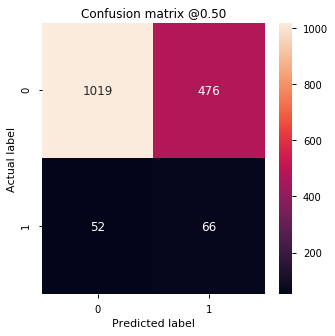

In [479]:
print("Balance random Forest results")
plot_cm(test_labels,BalancedRandomForest)

Easy ensemble trees results
Accuracy: 0.6311221326720396
balanced_accuracy: 0.6292783855790488
Precision: 0.1184
Recall: 0.6271186440677966
Roc-Auc: 0.6292783855790489
Legitimate Credit Default Detected (True Negatives):  944
Legitimate Credit Default Incorrectly Detected (False Positives):  551
Credit Default Missed (False Negatives):  44
Credit Default Detected (True Positives):  74
Total Credit Default:  118


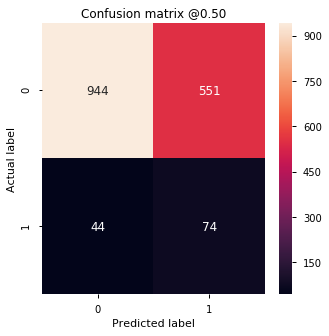

In [480]:
print("Easy ensemble trees results")
plot_cm(test_labels,EasyEnsemble)

Weighted Logistic regression results
Accuracy: 0.6819590824550527
balanced_accuracy: 0.6449946148177541
Precision: 0.13221601489757914
Recall: 0.6016949152542372
Roc-Auc: 0.6449946148177541
Legitimate Credit Default Detected (True Negatives):  1029
Legitimate Credit Default Incorrectly Detected (False Positives):  466
Credit Default Missed (False Negatives):  47
Credit Default Detected (True Positives):  71
Total Credit Default:  118


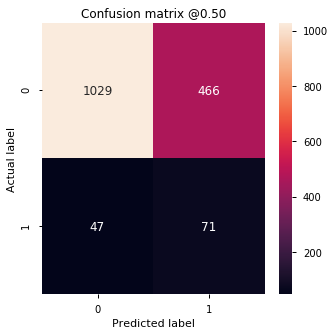

In [481]:
print("Weighted Logistic regression results")
plot_cm(test_labels,log_reg_weighted)

XGboost classic balance result
Accuracy: 0.7247365158090514
balanced_accuracy: 0.6368488180942123
Precision: 0.13938053097345132
Recall: 0.5338983050847458
Roc-Auc: 0.6368488180942123
Legitimate Credit Default Detected (True Negatives):  1106
Legitimate Credit Default Incorrectly Detected (False Positives):  389
Credit Default Missed (False Negatives):  55
Credit Default Detected (True Positives):  63
Total Credit Default:  118


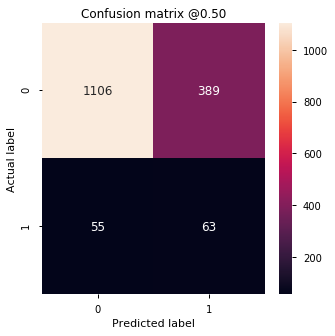

In [482]:
print("XGboost classic balance result")
plot_cm(test_labels,xgboost_classic_balance)

Optimized SVM results
Accuracy: 0.911965282083075
balanced_accuracy: 0.5778357235984355
Precision: 0.3235294117647059
Recall: 0.1864406779661017
Roc-Auc: 0.5778357235984354
Legitimate Credit Default Detected (True Negatives):  1449
Legitimate Credit Default Incorrectly Detected (False Positives):  46
Credit Default Missed (False Negatives):  96
Credit Default Detected (True Positives):  22
Total Credit Default:  118


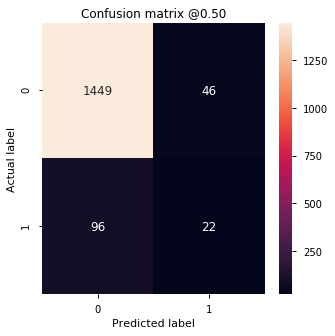

In [483]:
print("Optimized SVM results")
plot_cm(test_labels,svm_optimized)

Obtimized XGboost results
Accuracy: 0.7743335399876008
balanced_accuracy: 0.6128677512612664
Precision: 0.14450867052023122
Recall: 0.423728813559322
Roc-Auc: 0.6128677512612664
Legitimate Credit Default Detected (True Negatives):  1199
Legitimate Credit Default Incorrectly Detected (False Positives):  296
Credit Default Missed (False Negatives):  68
Credit Default Detected (True Positives):  50
Total Credit Default:  118


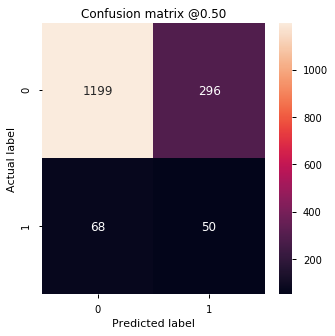

In [484]:
print("Obtimized XGboost results")
plot_cm(test_labels,xgboost_optimized)

### ROC-AUC Curves:

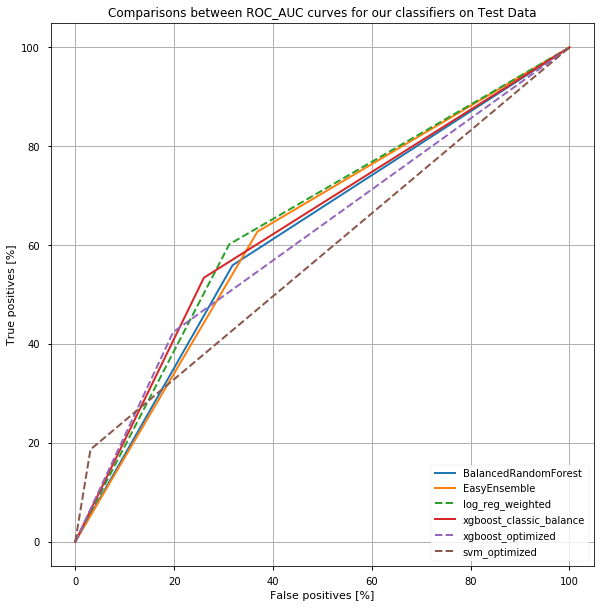

In [485]:
plot_roc("BalancedRandomForest", test_labels, BalancedRandomForest, color=colors[0])

plot_roc("EasyEnsemble", test_labels, EasyEnsemble, color=colors[1])

plot_roc("log_reg_weighted", test_labels, log_reg_weighted, color=colors[2], linestyle='--')

plot_roc("xgboost_classic_balance", test_labels, xgboost_classic_balance,  color=colors[3])
                                                                         
plot_roc("xgboost_optimized", test_labels, xgboost_optimized,  color=colors[4], linestyle='--')

plot_roc("svm_optimized", test_labels, svm_optimized,  color=colors[5], linestyle='--')

plt.legend(loc='lower right')

plt.title("Comparisons between ROC_AUC curves for our classifiers on Test Data")

plt.show()


$\textbf{Conclusion}$

-Balance Random Forest and XGBoost with classic weights seem to realize the best trade-off between Accuracy, Recall, Precision and ROC_AUC. Note that the selection is $\textbf{subjective}$. One would choose the model that give the best Recall because missing 1 is disastreous for the company, other would prefer to maximize f1 measure as refusing to grant credit to a lot of people (a lot of 0) is also disastrous (hence a trade-off between precision and recall). 

-Another remark is that this problem seems to need a more big dataset to train it $\textbf{correctly}$.

-The SVM optimized, which performed quite well on training set, seems to be overfitting since its performance on test set is nor that good.

$\textbf{Feature Selection}$: We tried different methods of features selection (Recursive Feature Elimination, PCA, Manual selection). None of them seemed to give better results. We decided to maintain all our features as they aren't correlated.

Below the most important features used by XGBoost with classic weights (according to their F-score)

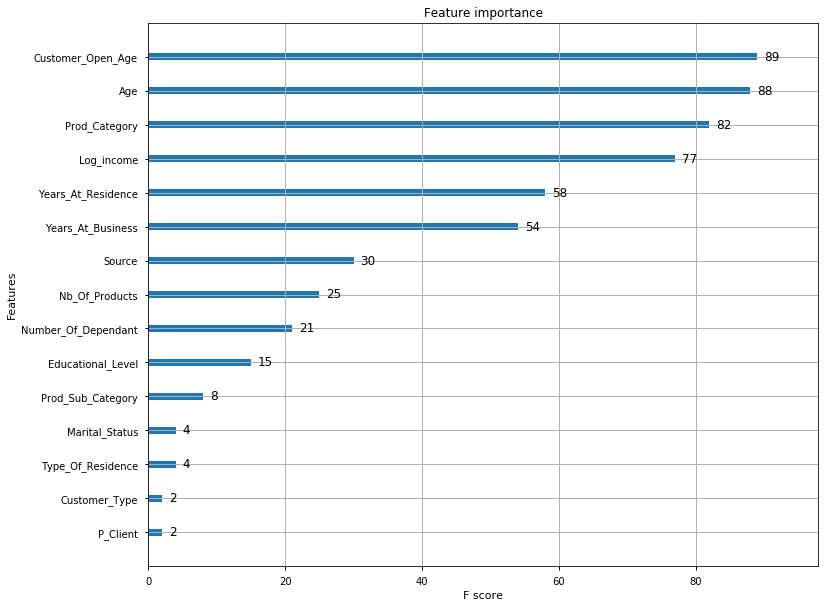

In [486]:
model=XGBClassifier(scale_pos_weight=12.7)
y=credit["Y"]
X=credit.drop(["Y"],axis=1)
model.fit(X,y)
xgb.plot_importance(model)
plt.show()